In [1]:
import math
import random
import numpy as np
import pandas as pd
import networkx as nx
import scipy as sc
from tqdm import tqdm

from matplotlib import pyplot as plt
from signet.cluster import Cluster
from sklearn.model_selection import train_test_split
#from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

In [2]:
# for google colab
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# reading the raw dataset which may contain duplicates, node ids out of range (id of nodes should be assigned from zero to number_of_nodes - 1)
#df_raw = pd.read_csv("Datasets/New_ Microsoft_ Excel_ Worksheet.csv")
df_raw = pd.read_csv("Datasets/soc-sign-epinions.csv")

In [4]:
df_raw

,source,target,sign
0,131828,131828,841372
1,1,2,-1
2,130144,2,1
3,5080,3,1
4,3,4,1
...,...,...,...
841368,92808,131814,-1
841369,131816,131817,1
841370,131819,131820,-1
841371,131824,131825,1


In [5]:
df_no_dup = df_raw.drop_duplicates(inplace = False)
df_no_dup = df_no_dup.reset_index(drop=True)

In [6]:
df_no_dup

,source,target,sign
0,131828,131828,841372
1,1,2,-1
2,130144,2,1
3,5080,3,1
4,3,4,1
...,...,...,...
841368,92808,131814,-1
841369,131816,131817,1
841370,131819,131820,-1
841371,131824,131825,1


In [7]:
# function to assign new ids to nodes regarding keeping ids in zero to num_of_nodes - 1
def relabel(df):
    source_old_labels = df["source"].drop_duplicates().to_numpy()
    #print(source_old_labels)
    target_old_labels = df["target"].drop_duplicates().to_numpy()
    all_old_labels = np.union1d(source_old_labels, target_old_labels)
    index_map = dict(enumerate(all_old_labels))
    new_index_map = dict([(value, key) for key, value in index_map.items()])
    #print(index_map == new_index_map)
    new_df = df.copy()
    for index, row in new_df.iterrows():
        #print(row["source"])
        row["source"] = new_index_map[row["source"]]
        row["target"] = new_index_map[row["target"]]
    return new_index_map, new_df

In [8]:
ind_map, df_relabled = relabel(df_no_dup)

#### اگر طوقه داشته باشه دیتاست نباید از MultiDiGraph استفاده شود

In [9]:
main_graph = nx.DiGraph()
main_graph = nx.from_pandas_edgelist(df = df_relabled, source = 'source', target = 'target', edge_attr = 'sign', create_using = nx.DiGraph(), edge_key = 'sign')

In [10]:
print('number of nodes G =', nx.number_of_nodes(main_graph) )
print('number of edges G =', nx.number_of_edges(main_graph) )
print('Density of G:', nx.density(main_graph))

number of nodes G = 131828
number of edges G = 841373
Density of G: 4.8414621282583676e-05


### توجه شود که اختلاف تعداد یال‎های گراف با سطرهای دیتافریم به دلیل وجود یال چندگانه یا طوقه در دیتا فریم است.

In [11]:
def graphTrainTestSplit(G, df, train_size, positive_size = 0.8):
    G_train = G.copy()
    train_df = df.copy()
    test_df = df.copy()
    edges_no = nx.number_of_edges(G_train)
    test_size = 1 - train_size
    
    # Get the indices of positive and negative labels
    positive_indices = train_df[train_df['sign'] == 1].index.to_list()
    negative_indices = train_df[train_df['sign'] == -1].index.to_list()
    
    # Shuffle the indices randomly
    random.shuffle(positive_indices)
    random.shuffle(negative_indices)
    
    # Calculate the number of positive and negative labels for test set
    negative_size = 1 - positive_size
    test_positive_count = int(test_size * edges_no * positive_size)
    test_negative_count = int(test_size * edges_no * negative_size)
    # test_positive_count = int(train_size * len(positive_indices))
    # test_negative_count = int(train_size * len(negative_indices))
    number_of_edges_left_for_removal = test_positive_count + test_negative_count
    
    edges_to_remove = []  # List to store edges for removal
    
    #print("number_of_edges_left_for_removal: ", number_of_edges_left_for_removal, 'test_positive_count:', test_positive_count, 'test_negative_count: ', test_negative_count)

    while number_of_edges_left_for_removal > 0:
        edges = np.array(G_train.edges)
        chosen_edge = random.choice(edges)
        source = chosen_edge[0]
        target = chosen_edge[1]
        
        if (G_train.degree[source] > 1 and G_train.degree[target] > 1):
            label = train_df.loc[(train_df['source'] == source) & (train_df['target'] == target), 'sign'].values[0]
            
            # Check if the edge label matches the desired distribution
            if (label == 1 and test_positive_count > 0) or (label == -1 and test_negative_count > 0):
                if G_train.has_edge(source, target):
                    edges_to_remove.append((source, target))
                    G_train.remove_edge(source, target)
                    if label == 1:
                        test_positive_count -= 1
                    else:
                        test_negative_count -= 1
                    number_of_edges_left_for_removal -= 1

    #print('edges_to_remove size: ', len(edges_to_remove))    
    # Remove the corresponding rows from the train DataFrame
    # train_df = train_df.drop(train_df[(train_df['source'].isin([edge[0] for edge in edges_to_remove])) &  (train_df['target'].isin([edge[1] for edge in edges_to_remove]))].index)
    
    mask = train_df[['source', 'target']].apply(tuple, axis=1).isin(edges_to_remove)
    train_df = train_df[~mask]

    test_df = test_df.merge(train_df, how='left', indicator=True)
    test_df = test_df[test_df['_merge'] == 'left_only'].drop('_merge', axis=1)
    
    return G_train, train_df, test_df


In [12]:
# def graphTrainTestSplit(G, df, train_size):
#     G_train = G.copy()
#     train_df = df.copy()
#     test_df = df.copy()
#     edges_no = nx.number_of_edges(G_train)
#     number_of_edges_left_for_removal = np.floor((1 - train_size) * edges_no)
#     while (number_of_edges_left_for_removal > 0):
#         edges = np.array(G_train.edges)
#         chosen_edge = random.choice(edges)
#         if (G_train.degree[chosen_edge[0]] > 1 and G_train.degree[chosen_edge[1]] > 1):
#             G_train.remove_edge(chosen_edge[0], chosen_edge[1])
            
#             # Get indexes where name column has value
#             index_names = train_df.index[(train_df['source'] == chosen_edge[0]) & (train_df['target'] == chosen_edge[1])]
#             # Delete these row indexes from dataFrame
#             train_df.drop(index_names, inplace = True)
            
#             number_of_edges_left_for_removal -= 1
#     test_df = test_df.merge(train_df, how='left', indicator=True)
#     test_df = test_df[test_df['_merge'] == 'left_only'].drop('_merge', axis=1)
#     return G_train, train_df, test_df

In [13]:
train_graph, train_df, test_df = graphTrainTestSplit(main_graph, df_relabled, 0.99987163838155015670814252418369)

In [14]:
train_df

,source,target,sign
0,131827,131827,841372
1,0,1,-1
2,130143,1,1
3,5079,2,1
4,2,3,1
...,...,...,...
841368,92807,131813,-1
841369,131815,131816,1
841370,131818,131819,-1
841371,131823,131824,1


In [15]:
test_df

,source,target,sign
526,9289,5,1
18171,49421,219,1
26779,10854,364,1
29863,23846,372,1
34003,3923,430,1
...,...,...,...
810129,81809,108714,1
812659,1480,110205,1
815477,118696,111875,1
825395,118802,117581,1


In [16]:
num_duplicates = test_df.duplicated().sum()
print("Number of duplicates:", num_duplicates)


Number of duplicates: 0


In [17]:
rows = train_df.loc[:, "source"].to_numpy()
cols = train_df.loc[:, "target"].to_numpy()
sign = train_df.loc[:, "sign"].to_numpy()

In [18]:
p_rows = [rows[i] for i in range(len(rows)) if sign[i] == 1]
p_cols = [cols[i] for i in range(len(cols)) if sign[i] == 1]
p_data = np.ones(len(p_rows))

n_rows = [rows[i] for i in range(len(rows)) if sign[i] == -1]
n_cols = [cols[i] for i in range(len(cols)) if sign[i] == -1]
n_data = np.ones(len(n_rows))

In [19]:
nodes_no = nx.number_of_nodes(train_graph)
edges_no = nx.number_of_edges(train_graph)

In [20]:
A_p = sc.sparse.csc_matrix((p_data, (p_rows, p_cols)), shape = (nodes_no , nodes_no))
A_n = sc.sparse.csc_matrix((n_data, (n_rows, n_cols)), shape = (nodes_no , nodes_no))

In [21]:
print(p_data.shape)
print(n_data.shape)

(717581,)
(123684,)


# اینجاااااااااااااااااااااااااااااااااااااااااااااااااااااا

In [22]:
def getNeighborsOfANode(graph, node):
    x = []
    for v in graph.nodes():
        if ((v, node) in graph.edges()):
            x.append(v)
    return np.array(x)

In [23]:
# def NodeswithoutInAndOutneighbors(G, sign_tag = 'sign'):
#     nodes_no = nx.number_of_nodes(G)
#     sign_map = nx.get_edge_attributes(G, sign_tag)
#     n = 0
#     for u in G.nodes():
#         for v in G.nodes():
#             #print("u: ", u, ", v: ", v)
#             if (u != v):
#                 u_neighbors = set(G.adj[u])
#                 v_neighbors = set(G.adj[v])
#                 uv_neighbors = list(u_neighbors.intersection(v_neighbors))
#                 u_inneighbors = set(getNeighborsOfANode(G, u))
#                 v_inneighbors = set(getNeighborsOfANode(G, v))
#                 uv_inneighbors = list(u_inneighbors.intersection(v_inneighbors))
#                 if (len(uv_neighbors) + len(uv_inneighbors)) == 0 and (u,v) in G.edges():
#                     n = n+1
#                     print("(u,v):" , (u,v))
#     return n

In [24]:
#c = Cluster((A_p, A_n))

In [25]:
def getClusters(G, k, A_p, A_n):
    c = Cluster((A_p, A_n))
    #spec_clus = c.spectral_cluster_adjacency(k = 5, normalisation = 'sym_sep', eigens = None, mi = None)
    spec_clus = c.spectral_cluster_bnc(k = 5, normalisation='sym', eigens=None, mi=None)
    clusters = []
    for j in range(k):
        clusters.append([i for i in G.nodes() if spec_clus[int(i - 1)] == j])
    return np.array(clusters, dtype = np.ndarray)

In [26]:
main_clusters = getClusters(train_graph, 5, A_p, A_n)
cluster1 = main_clusters[0]
cluster2 = main_clusters[1]
cluster3 = main_clusters[2]
cluster4 = main_clusters[3]
cluster5 = main_clusters[4]

C:\Users\Alireza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [27]:
print(len(cluster1))
print(len(cluster2))
print(len(cluster3))
print(len(cluster4))
print(len(cluster5))

43125
40540
40764
3809
3590


In [28]:
def getCommonNeighbors(G, cl1, cl2):
    x = set([])
    for i in cl1:
        x = x.union(set(G.adj[i]))
    #print('x: ', x)
    y = set([])
    for j in cl2:
        y = y.union(set(G.adj[j]))
    #print('y: ', y)
    return list(x.intersection(y))

In [29]:
def locationOfANode(clusters, u):
    n = clusters.shape[0]
    x = np.zeros(n)
    r = -1
    for i in range(n):
        if u in clusters[i]:
            r = i
    return r

In [30]:

def locationOfArrayOfNode(clusters, U):
    x = np.zeros(len(U))
    for i in range(len(x)):
        x[i] = locationOfANode(clusters, U[i])
    return x

In [31]:
def getClusterSimiliarity(G, source_cluster, common_neighbors, sign_tag = 'sign'):
    #print('common_neighbors: ', common_neighbors)
    sign_map = nx.get_edge_attributes(G, sign_tag)
    epsilon = 10 ** (-5)
    y = []
    for v in common_neighbors:
        # adding an epsilon to prevent mean of an empty array
        #x = [epsilon]
        x = []
        for u in source_cluster:
            if (u, v) in G.edges():
                x.append(sign_map[(u, v)])
                #print("u", u , "v" , v)
        y.append(np.mean(np.array(x)))
    return np.array(y)

##################

In [32]:
# main function to calculate the similiarity between two clusters
def getInterClusterSimiliarity(G, cl1, cl2, common_neighbors):
   y1 = getClusterSimiliarity(G, cl1, common_neighbors)
   y2 = getClusterSimiliarity(G, cl2, common_neighbors)
   
   # if (y1.size == 0):
   #    print('y1: ', y1)
   #    print('###', common_neighbors)
   # if (y2.size == 0):
   #    print('y2: ', y2)
   #    print('###', common_neighbors)

   alpha = np.dot(y1.T, y2)

   ##first approach
   beta = np.dot(y1.T, y1)
   gamma = np.dot(y2.T, y2)
   if (beta * gamma < 0):
      print('it"s negative: ', beta * gamma)
   epsilon = 10 ** (-5)
   #return alpha / (np.sqrt((beta * gamma)) + epsilon)
   return alpha / (np.sqrt((beta * gamma)))

   ##second approach
   #return alpha / len(common_neighbors)

In [33]:
# # calculates similiarities between each two clusters and returns a matrix
# def getAllSimiliaritiesBetweenClusters(G, clusters):
#     clusters_no = clusters.shape[0]
#     similiarities = np.zeros(shape = (clusters_no, clusters_no))
#     for i in range(clusters_no):
#         for j in range(i, clusters_no):
#             common_neighbors = getCommonNeighbors(G, clusters[i], clusters[j])
#             current_similiarity = getInterClusterSimiliarity(G, clusters[i], clusters[j], common_neighbors)
#             # similiarities[i][j] = similiarities[j][i] = current_similiarity
#             if len(common_neighbors) == 0:
#                 print('i:', clusters[i])
#                 print('j:', clusters[j])
#             if (math.isnan(current_similiarity)):
#                 similiarities[i][j] = similiarities[j][i] = 0
#             else:
#                 similiarities[i][j] = similiarities[j][i] = current_similiarity
#     return similiarities

In [34]:
# Calculates similarities between each two clusters and returns a matrix
def getAllSimilaritiesBetweenClusters(G, clusters):
    clusters_no = clusters.shape[0]
    similiarities = np.zeros(shape=(clusters_no, clusters_no))
    total_iterations = clusters_no * (clusters_no + 1) // 2  # Total number of iterations for progress bar

    with tqdm(total=total_iterations, desc="Calculating similarities") as pbar:
        for i in range(clusters_no):
            for j in range(i, clusters_no):
                if i == j:
                    similiarities[i][j] = 1
                else:
                    common_neighbors = getCommonNeighbors(G, clusters[i], clusters[j])
                    current_similarity = getInterClusterSimiliarity(G, clusters[i], clusters[j], common_neighbors)

                    if len(common_neighbors) == 0:
                        print('i:', clusters[i])
                        print('j:', clusters[j])
                    if math.isnan(current_similarity):
                        similiarities[i][j] = similiarities[j][i] = 0
                    else:
                        similiarities[i][j] = similiarities[j][i] = current_similarity

                pbar.update(1)  # Update the progress bar

    return similiarities

In [35]:
# common_neighbors = getCommonNeighbors(train_graph, cluster1, cluster2)
# similarity = getInterClusterSimiliarity(train_graph, cluster1, cluster2, common_neighbors)
# similarity

In [36]:
matrix_of_similarity = getAllSimilaritiesBetweenClusters(train_graph, main_clusters)
matrix_of_similarity

Calculating similarities: 100%|██████████| 15/15 [1:33:01<00:00, 372.07s/it] 


array([[1.  , 0.83, 0.81, 0.8 , 0.81],
       [0.83, 1.  , 0.81, 0.79, 0.8 ],
       [0.81, 0.81, 1.  , 0.81, 0.82],
       [0.8 , 0.79, 0.81, 1.  , 0.76],
       [0.81, 0.8 , 0.82, 0.76, 1.  ]])

In [57]:
def signPrediction(G, main_clusters, all_similiarities, k, u, v, threshold, w1, sign_tag = "sign"):
    sign_map = nx.get_edge_attributes(G, sign_tag)
    #main_clusters = getClusters(G, k)
    
    u_c = locationOfANode(main_clusters, u)
    u_v = locationOfANode(main_clusters, v)
    cl1 = main_clusters[u_c]
    cl2 = main_clusters[u_v]
    #s_AB = getCommonNeighbors(G, cl1, cl2)
    #print(s_AB)
    S = getNeighborsOfANode(G, v)
    S_c = locationOfArrayOfNode(main_clusters, S)
    n = len(S)
    x = np.zeros(n)
    for i in range(n):
        #x[i] = getInterClusterSimiliarity(main_clusters[u_c], main_clusters[int(S_c[i])], s_AB)
        x[i] = all_similiarities[u_c][int(S_c[i])]
        #print('main_clusters_u_c: ', main_clusters[u_c])
        #print('main_clusters_int: ', main_clusters[int(S_c[i])])
        #print('s_AB: ', s_AB)
        #print('x[i]' , x[i]  )
        
        if locationOfANode(main_clusters, u) == locationOfANode(main_clusters, S_c[i]):
            x[i] = w1 * x[i]
        else:
            x[i] = (1 - w1) * x[i]
        
    r = np.zeros(n)
    for i in range(n):
        r[i] = sign_map[(S[i], v)]
    #print('x: ', x)
    #print('r: ', r)
    #if (np.sum(x) == 0):
    #    print('it is zero')
    epsilon = 10 ** (-5)
    #result = (np.dot(x.T, r)) / (np.sum(x) + epsilon)
    result = (np.dot(x.T, r)) / (np.sum(x))
    if result > threshold:
        return 1
    else:
        return -1

In [48]:
from tqdm.auto import tqdm

C:\Users\Alireza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
# # Create a new column 'sign prediction' in test_df with sign predictions
# def calculateSignPredictions(train_graph, main_clusters, test_df):
#     with tqdm(total=len(test_df), desc="Calculating sign predictions", bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}') as pbar:
#         test_df['sign prediction'] = test_df.apply(lambda row: signPrediction(train_graph, main_clusters, matrix_of_similarity, 5, row['source'], row['target'], 0, 0.75), axis=1)
#         pbar.update(len(test_df))  # Update the progress bar to complete

#     return test_df


In [64]:
# Create a new column 'sign prediction' in test_df with sign predictions
def calculateSignPredictions(train_graph, main_clusters, test_df, w):
    new_test_df = test_df.copy()
    tqdm.pandas()
    new_test_df['sign prediction'] = new_test_df.progress_apply(lambda row: signPrediction(train_graph, main_clusters, matrix_of_similarity, 5, row['source'], row['target'], 0, w), axis=1)
    return new_test_df


In [54]:
# zz = np.zeros(test_df.shape[0])
# # Call the function with the required parameters
# new_test_df = calculateSignPredictions(train_graph, main_clusters, test_df, 0.75)
# confusion_matrix(new_test_df['sign'], new_test_df['sign prediction'])
# acc_temp = accuracy_score(new_test_df['sign'], new_test_df['sign prediction'],  normalize=True, sample_weight=None)
# f_temp = f1_score(new_test_df['sign'], new_test_df['sign prediction'])

 63%|██████▎   | 67/107 [03:27<00:39,  1.02it/s]<ipython-input-37-43a853b88aaa>:37: RuntimeWarning: invalid value encountered in double_scalars
  result = (np.dot(x.T, r)) / (np.sum(x))
100%|██████████| 107/107 [04:05<00:00,  2.30s/it]


In [55]:
# print(acc_temp)
# print(f_temp)

0.8878504672897196
0.9325842696629213


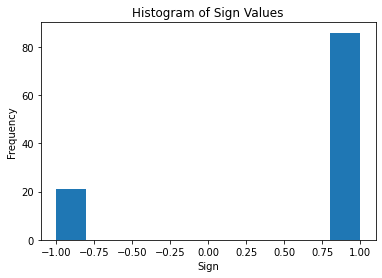

In [56]:
# plt.hist(test_df['sign'])

# # Set the labels and title of the histogram
# plt.xlabel('Sign')
# plt.ylabel('Frequency')
# plt.title('Histogram of Sign Values')

# # Display the histogram
# plt.show()




In [71]:
acc_y = []
f_y = []
for w in [0.1, 0.3, 0.5, 0.7, 0.9, 1]:
    new_test_df = calculateSignPredictions(train_graph, main_clusters, test_df, w)
    confusion_matrix(new_test_df['sign'], new_test_df['sign prediction'])
    acc_temp = accuracy_score(new_test_df['sign'], new_test_df['sign prediction'],  normalize=True, sample_weight=None)
    f_temp = f1_score(new_test_df['sign'], new_test_df['sign prediction'])
    print('acc:', acc_temp, 'f1:', f_temp)
    acc_y.append(acc_temp)
    f_y.append(f_y)

 63%|██████▎   | 67/107 [08:42<01:17,  1.94s/it]<ipython-input-57-6daae620cf7a>:37: RuntimeWarning: invalid value encountered in double_scalars
  result = (np.dot(x.T, r)) / (np.sum(x))
100%|██████████| 107/107 [09:59<00:00,  5.60s/it]


acc: 0.8878504672897196 f1: 0.9325842696629213


 63%|██████▎   | 67/107 [08:30<01:15,  1.88s/it]<ipython-input-57-6daae620cf7a>:37: RuntimeWarning: invalid value encountered in double_scalars
  result = (np.dot(x.T, r)) / (np.sum(x))
100%|██████████| 107/107 [09:45<00:00,  5.47s/it]


acc: 0.8878504672897196 f1: 0.9325842696629213


  2%|▏         | 2/107 [00:41<35:58, 20.55s/it]


KeyboardInterrupt: 